In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from typing import Tuple, List, Dict, Callable
from scipy.interpolate import interp1d
plt.style.use("ggplot")

In [67]:
df = pd.read_csv("datos_movimiento_horizontal.csv", sep=";")
replace_commas_by_dot = lambda df, col: df[col].str.replace(",",".")
df.t = replace_commas_by_dot(df, "t")
df.x = replace_commas_by_dot(df, "x")
df = df.astype("float")
df = df.iloc[1:, :]
df

,t,x
1,0.0333,0.0435
2,0.0667,0.0748
3,0.1000,0.1000
4,0.1330,0.1230
5,0.1670,0.1450
6,0.2000,0.1670
7,0.2330,0.1870
8,0.2670,0.2030
9,0.3000,0.2190
10,0.3330,0.2330


<Figure size 576x360 with 0 Axes>

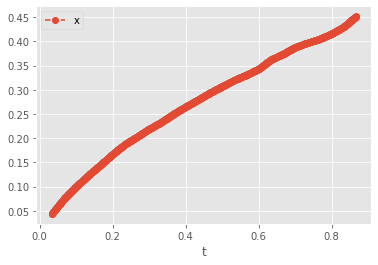

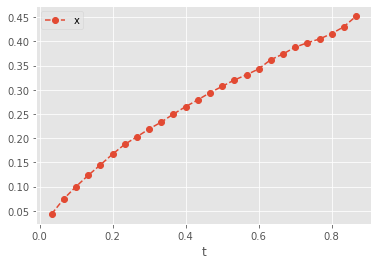

In [68]:
f = interp1d(df.t, df.x)
dominio = np.linspace(df.t.values[0], df.t.values[-1], 1000)
data = {
    "t": dominio,
    "x": f(dominio) 
}
plt.figure(figsize=(8,5))
df2 = pd.DataFrame(data)
df2.set_index("t").plot(label="Interpolated", linestyle="--", marker="o")
df.set_index("t").plot(label="Original",linestyle="--", marker="o")
plt.legend()
plt.show()

In [69]:
def add_velocity(df: pd.DataFrame) -> pd.DataFrame:
        vx = [np.nan]
        xs = df.x.values
        ts = df.t.values

        for i in range(len(df)):
                if i > 0 and i+1 < len(df):
                        vel_x = (xs[i+1] - xs[i-1]) / \
                                (ts[i+1] - ts[i-1] )
                        vx.append(vel_x)

        vx.append(np.nan)
        df["vx"] = vx
        return df

df = add_velocity(df)
df2 = add_velocity(df2)
df2

,t,x,vx
0,0.033300,0.043500,NaN
1,0.034135,0.044282,0.937126
2,0.034969,0.045064,0.937126
3,0.035804,0.045846,0.937126
4,0.036638,0.046628,0.937126
...,...,...,...
995,0.863662,0.449840,0.647059
996,0.864496,0.450380,0.647059
997,0.865331,0.450920,0.647059
998,0.866165,0.451460,0.647059


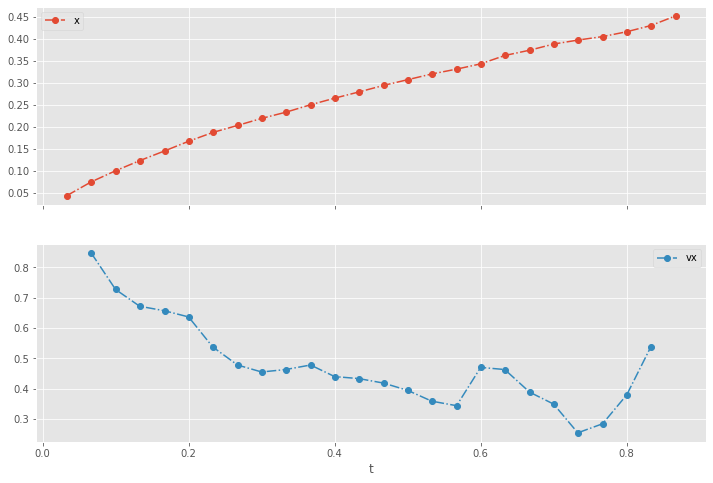

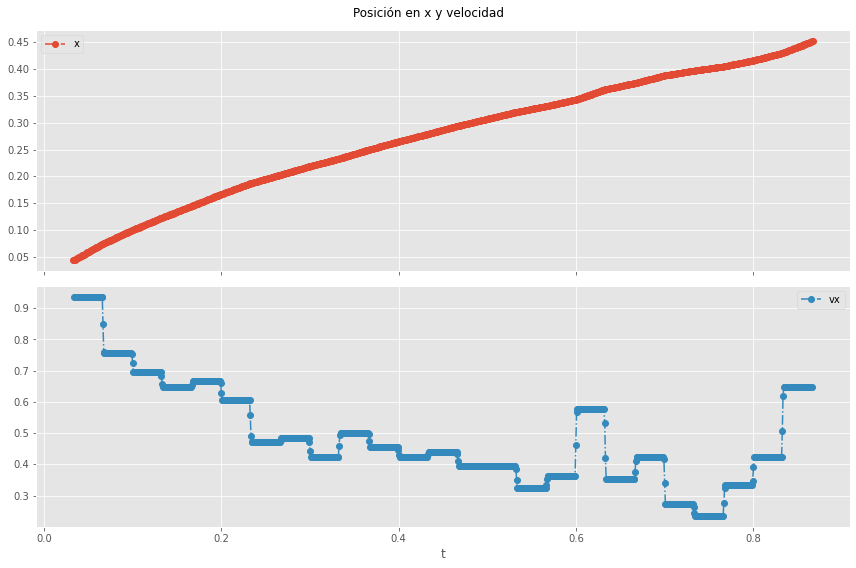

In [70]:
df.set_index("t").plot(subplots=True, figsize=(12,8), linestyle="dashdot", marker="o")
df2.set_index("t").plot(subplots=True, figsize=(12,8), linestyle="dashdot", marker="o")
plt.gcf().suptitle("Posición en x y velocidad")
plt.tight_layout()
plt.show()

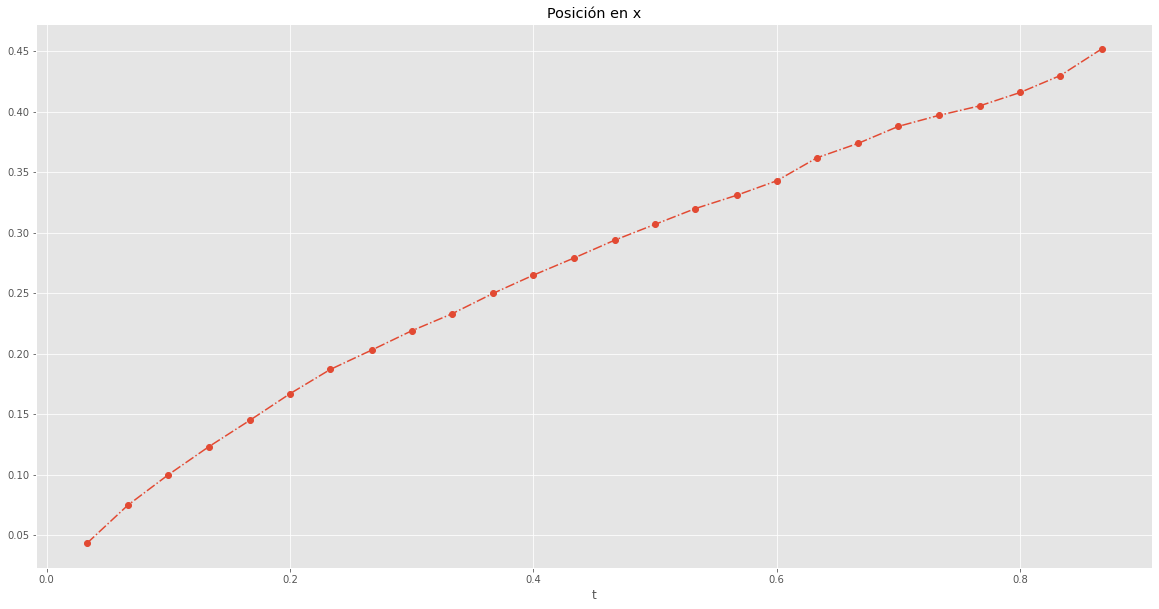

In [71]:
df.set_index("t")["x"].plot(figsize=(20,10), linestyle="dashdot", marker="o")
plt.title("Posición en x")
plt.show()

In [72]:
time_arr = np.expand_dims(df.t.values, 1)
x_arr = np.expand_dims(df.x.values, 1)

In [73]:
lr = LinearRegression().fit(time_arr, x_arr)
print(lr.coef_)
lr.intercept_

[[0.45585283]]


array([0.06826238])

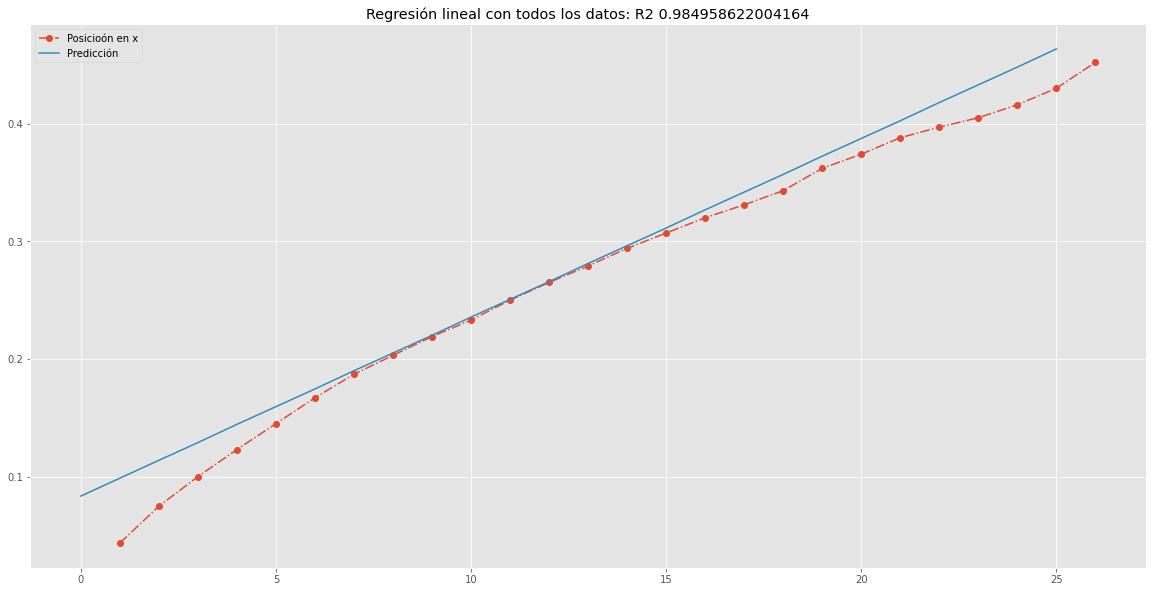

In [74]:
preds = lr.predict(time_arr)

df["x"].plot(figsize=(20,10), marker="o", linestyle="dashdot", label="Posicioón en x")
plt.plot(preds, label="Predicción")
r2 = r2_score(preds, x_arr)
plt.title(f"Regresión lineal con todos los datos: R2 {r2}")
plt.legend()
plt.show()

[[0.4517401]]
[0.07111029]


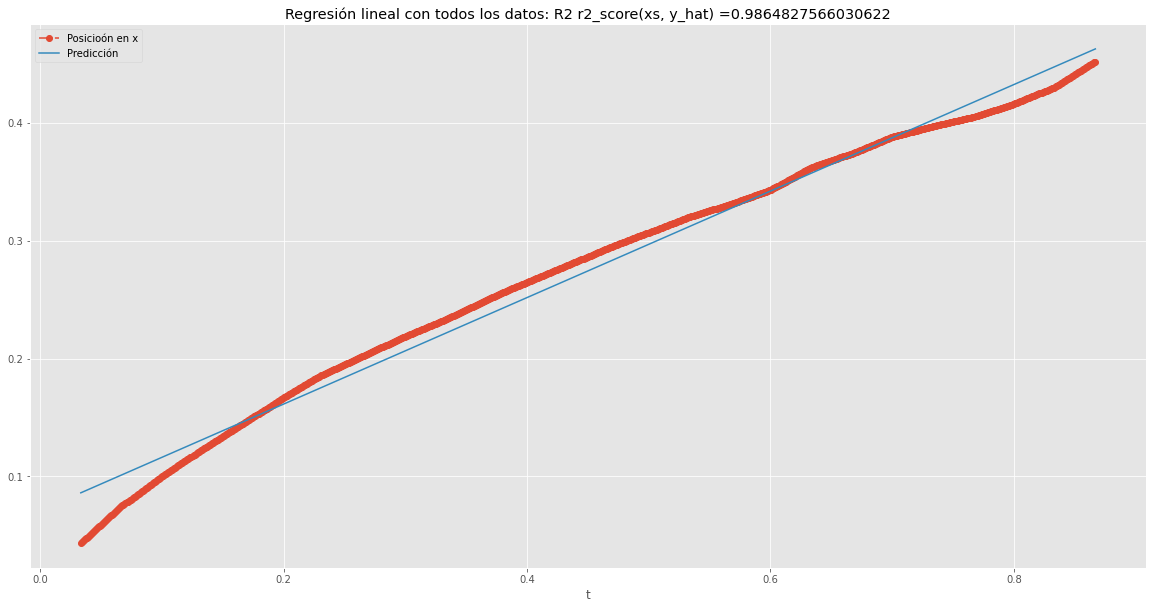

In [84]:
time = df2.t.values.reshape(-1,1)
xs = df2.x.values.reshape(-1,1)
lr = LinearRegression().fit(time, xs)
print(lr.coef_)
print(lr.intercept_)
y_hat = lr.predict(time)

df2.set_index("t")["x"].plot(figsize=(20,10), marker="o", linestyle="dashdot", label="Posicioón en x")
plt.plot(time, y_hat, label="Predicción")
plt.title(f"Regresión lineal con todos los datos: R2 {r2_score(xs, y_hat) =}")
plt.legend()
plt.show()

## Ajustar modelos distintos para intervalos

Intervalos de 0 a 5, de 5 a 20, y de 20 en adelante

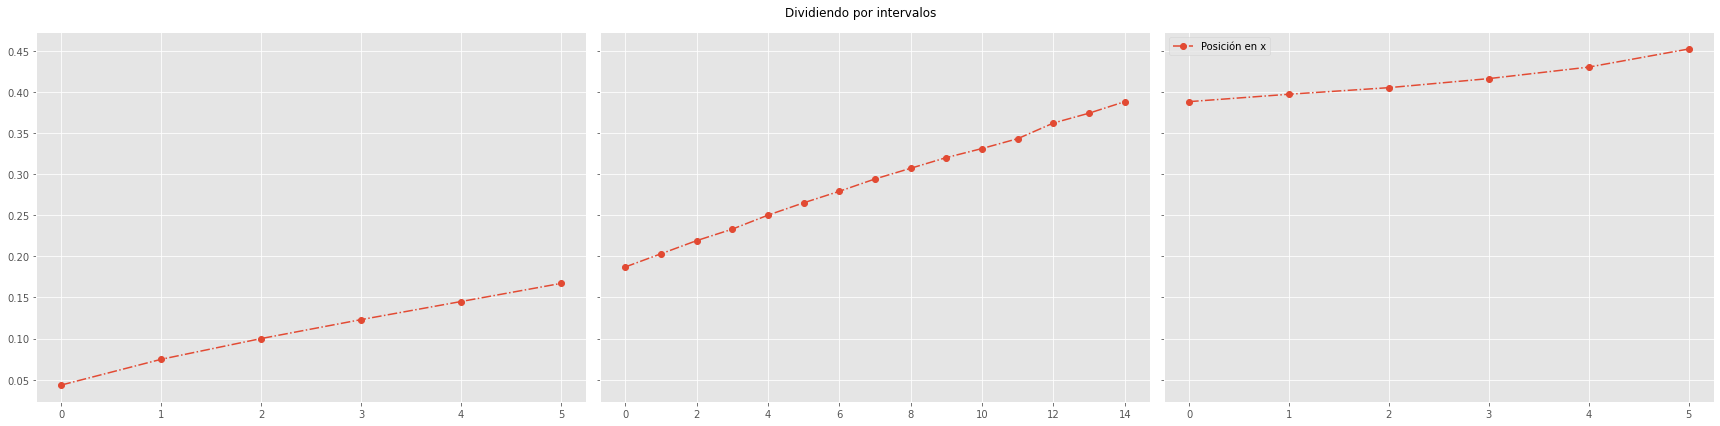

In [20]:
intervals = [range(0,6), range(6,21), range(20, len(df))]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*8,6), sharey=True)
fig.suptitle("Dividiendo por intervalos")

for i, interval in enumerate(intervals):
    ax[i].plot(df.x.values[interval], linestyle="dashdot", marker="o", label="Posición en x")

plt.legend()
plt.tight_layout()
plt.show()

In [114]:
clfs = dict()
degrees = list(range(1,3+1))
data = dict(
    degrees=degrees
)

def fit_polynomial_reg(
        d: float, X: np.ndarray, y: np.ndarray
    ) -> Tuple[float, Tuple[LinearRegression, PolynomialFeatures]]:
    poly = PolynomialFeatures(d)
    X_ = poly.fit_transform(X)

    clf = LinearRegression()
    clf.fit(X_, y)
    preds = clf.predict(X_)
    r2 = r2_score(y, preds)
    return r2, (clf, poly) 
    
prudent = False
for interval in intervals:
    interval_str = f"[{interval.start}-{interval.stop})"
    if interval_str not in data:
        data[interval_str] = []
    for d in degrees:
        X = np.expand_dims(df.t.values[interval], axis=0).T
        y = np.expand_dims(df.x.values[interval], axis=0).T
        
        r2, clf = fit_polynomial_reg(d, X, y) 
        prev_r2 = data[interval_str]
        if prudent:
            if len(prev_r2) > 1:
                max_prev_r2 = max(prev_r2)
                if max_prev_r2 < 1 and r2 > max_prev_r2:
                    clfs[interval] = clf
        else:
            clfs[interval] = clf     
        data[interval_str].append(r2)
        
pd.DataFrame(data)

,degrees,[0-6),[6-21),[20-26)
0,1,0.995234,0.998387,0.961916
1,2,0.999349,0.999258,0.996150
2,3,0.999978,0.999490,0.999878


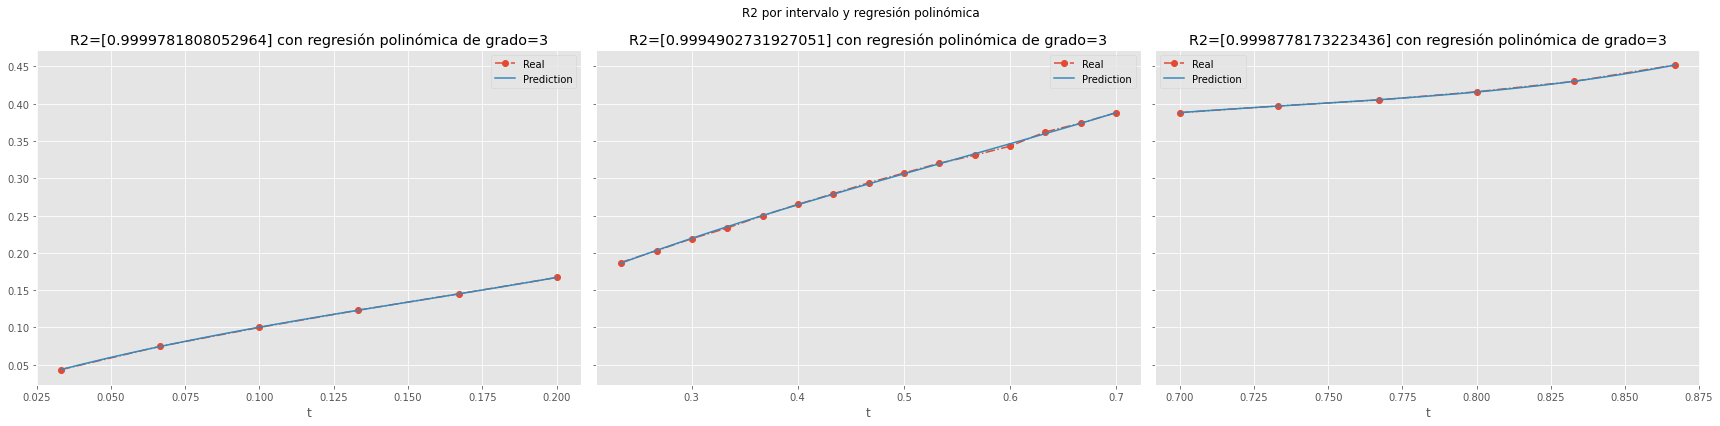

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*8, 6), sharey=True)
fig.suptitle("R2 por intervalo y regresión polinómica")

for i, (interval, (clf, poly)) in enumerate(clfs.items()):
    
    X = df.t.values[interval]
    X_linspace = np.linspace(X[0], X[-1], 100).reshape(-1, 1)
    y = df.x.values[interval].reshape(-1, 1)
    
    X_linspace = poly.transform(X_linspace)
    X_ = poly.transform(X.reshape(-1,1)) 
   
    y_hat = clf.predict(X_linspace)
    y_hat_compare = clf.predict(X_)
    r2 = r2_score(y, y_hat_compare)

    ax[i].set_title(f"R2=[{r2}] con regresión polinómica de grado={poly.degree}")
    ax[i].plot(X, y,label="Real", marker="o", linestyle="dashdot")
    ax[i].plot(X_linspace[:,1], y_hat, label="Prediction")
    ax[i].set_xlabel("t")
    ax[i].legend()

plt.tight_layout()
plt.show()

In [116]:
# ^
for interval, (linear_regression, _) in clfs.items():
    coefs = " + ".join(["({})*x**{}".format(c, i) for i,c in enumerate(linear_regression.coef_[0][1:], start=1)])
    equation_str = f"{linear_regression.intercept_[0]} + {coefs}"
    print(f"Intervalo: [{interval.start},{interval.stop})")
    print(f"Polinomio: {equation_str}")
    print()

Intervalo: [0,6)
Polinomio: 0.005842829982451503 + (1.2559622832031307)*x**1 + (-3.96921878089112)*x**2 + (8.596516290226853)*x**3

Intervalo: [6,21)
Polinomio: 0.038262545871375064 + (0.7677046597479071)*x**1 + (-0.6683934199232322)*x**2 + (0.40740081922400295)*x**3

Intervalo: [20,26)
Polinomio: -4.100273846207975 + (17.763942088184322)*x**1 + (-23.696218014932015)*x**2 + (10.684274784452771)*x**3



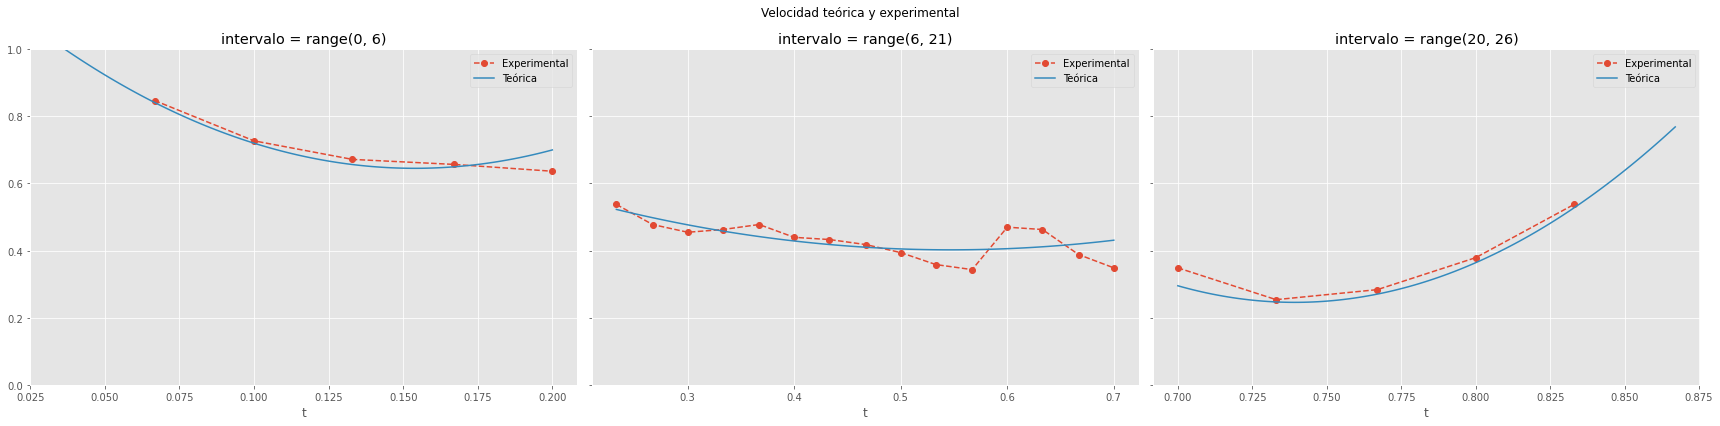

In [117]:
def get_derivative_poly(
    clf: LinearRegression,
    poly: PolynomialFeatures
) -> Callable[[float], float]:
    def f(x: np.ndarray) -> float:
        x_ = poly.transform(x)[:, :-1]
        betas = clf.coef_[:, 1:].T
        one_to_n = np.expand_dims(np.arange(len(betas)), -1) + 1
        derivatives = np.dot(x_,( one_to_n * betas))
        return derivatives
    return f

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*8, 6), sharey=True)
fig.suptitle("Velocidad teórica y experimental")

for i, (intervalo, (clf, poly)) in enumerate(clfs.items()):
    derivative = get_derivative_poly(clf, poly)
    
    time = df.t.values[intervalo]
    time_theoretical = np.linspace(time[0], time[-1], 100).reshape(-1, 1)
    
    experimental_velocity = df.vx.values[intervalo]
    theroetical_velocity = derivative(time_theoretical)

    ax[i].set_title(f"{intervalo = }")
    ax[i].plot(time, experimental_velocity,label="Experimental", linestyle="--", marker="o")
    ax[i].plot(time_theoretical, theroetical_velocity, label="Teórica")
    ax[i].set_xlabel("t")
    ax[i].legend()

plt.ylim([0,1])
plt.tight_layout()
plt.show()